# Experimental Emulator class

The purpose of this notebook is to design an emulator class, which allows one to do successive updates on the prior knowledge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_LHS(n_params=2, N_samples=10):
    """ 
    Constructs an initial sample as a Latin-hypercube sample, assuming
    the parameters are in the [0,1] interval.
        
    NB this *not* a max-min LHS
    """
    X = np.empty((N_samples, n_params))
    base = np.linspace(0, 1, N_samples)
    for i in range(n_params):
        np.random.shuffle(base)
        X[:,i] = base

    return X


def arr(x):
    return np.array(x)


In [141]:
class Emulator:
    """
    
    Parameters
    ----------
    Xi : numpy.ndarray
        An array of points where the function was evaluated
    D : numpy.ndarray
        Values of the evaluated function
    emulator : Emulator
        Previous 
    
    """
    def __init__(self, Xi, D, emulator=None, beta=None, sigma=None, theta=None):
        
        self.previous_emulator = None
        
        if len(Xi.shape)==1:
            Xi = Xi[:,np.newaxis]
        self.Xi = Xi
        self.D = D
        
        if sigma is not None:
            self.sigma2 = sigma**2
        if theta is not None:
            self.theta2 = theta**2
        self.beta = beta
        
    def p_E_f(self,x):
        return np.ones((x.shape[0],1))*self.beta

    def p_Var_f(self, x):
        return self.sigma2*np.ones((x.shape[0],1))

    def p_E_D(self, x, D):
        return self.beta*np.ones((D.size, 1))

    def p_cov_f_D(self, x, xi):
        size, n_pars = x.shape
        n_D, n_pars2 = xi.shape
        assert n_pars == n_pars2

        cov = np.ones((size, n_D))*np.sqrt(self.sigma2)
        for i in range(size):
            for j in range(n_D):
                d = x[i,:]-xi[j,:]
                d2 = d @ d
                cov[i,j] = self.sigma2 * np.exp(-d2/self.theta2)
        return cov

    def p_Var_D(self, xi):
        return self.p_cov_f_D(xi,xi)   

    def adj_E(self, x, xi, D):
        # One could invert the matrix here:
        # inv_VD = np.linalg.inv(self.p_Var_D(xi))
        # but a faster and more stable choice is solving
        VD = self.p_Var_D(xi)
        r = np.linalg.solve(VD, (self.D-self.p_E_D(x,D)))
        #        E[f(x)] + Cov[f(x),D] inv_Var[D] (D-E[D]) 
        return self.p_E_f(x) + (self.p_cov_f_D(x, xi) @ r)

    def adj_Cov(self, x, xi, D):
        
        cov_f_D =  self.p_cov_f_D(x,xi)
        cov_D_f = cov_f_D.T
        VD = self.p_Var_D(xi)
        
        # One could invert the matrix here:
        # inv_VD = np.linalg.inv(VD)
        # adj = cov_f_D @ (inv_VD @ cov_D_f)
        # but a better (faster and more stable) option is defining:        
        # r = inv_VD @ cov_D_f
        # thus, cov_D_f = VD @ r
        # and finding r through solving the system
        r = np.linalg.solve(VD, cov_D_f)
        adj = cov_f_D @ r        
        # We are not really interested in the covariances associated with
        # multiple samples (?) only in the variance,
        # thus the use of the diagonal
        return self.p_Var_f(x) - adj.diagonal()[:,np.newaxis]
    
    def E(self, X):
        
        if len(X.shape)==1:
            X = X[:,np.newaxis]

        return self.adj_E(X, self.Xi, self.D)
    def Var(self, X):
        if len(X.shape)==1:
            X = X[:,np.newaxis]

        return self.adj_Cov(X, self.Xi, self.D)
    
    

In [142]:
beta = 0.5
sigma = 0.6
theta = 0.06

In [143]:
def minimum_spacing(xi):
    r = 1e30
    
    for k in xi:
        d = np.abs(xi-k)
        r = min(r, (d[d>0]).min())
    return r

def L(x):
    return 3*x *np.sin(5*np.pi*(x-0.1)/0.4)


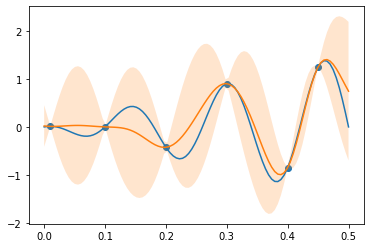

In [144]:
t = np.linspace(0,0.5,100)
xi = np.array([0.01,0.1, 0.2, 0.3, 0.4,0.45])
D = L(xi)[:,np.newaxis]

em = Emulator(xi, D, beta=D.mean(), sigma=D.var(), 
              theta=0.05)

aE = em.E(t)
aCov = np.sqrt(em.Var(t))

plt.plot(t, L(t))
plt.scatter(xi, D)

plt.plot(t, aE)
plt.fill_between(t, y2=(aE+3*aCov).ravel(), y1=(aE-3*aCov).ravel(),alpha=0.2)

In [145]:
def f(X):
    x = 2*X[...,0]-1
    y = 2*X[...,1]-1
    r = (np.exp(-((x+.2)**2+2*(y+.2)**2+x*y*0.8)/.32) 
         + np.exp(-((x-.2)**2+(y-.4)**2)/.17))
    return r.reshape(x.shape)


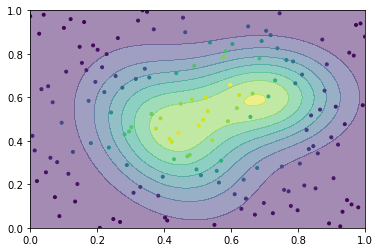

In [146]:
Xi = generate_LHS(N_samples=150)
D = f(Xi)[:,np.newaxis]

t = np.linspace(0,1,100)
Xt = np.vstack([[*np.meshgrid(t,t)]]).T
plt.contourf(t,t,f(Xt),alpha=0.5)
plt.scatter(Xi[:,0],Xi[:,1], c=f(Xi), marker='.')

In [147]:
em_2D = Emulator(Xi, D, beta=D.mean(), sigma=0.5, 
              theta=0.04)

In [148]:
X = generate_LHS(n_params=2, N_samples=20)



pred  = em_2D.E(X)
var = em_2D.Var(X)
err = np.sqrt(var)

In [149]:
var.min()

0.004733159931393532

In the plot below, the boxes show the predictions by the emulator. Their sizes correspond to the confidence (i.e. inverse relative error).

The confidence is (of course) higher where the density of points is also higher.

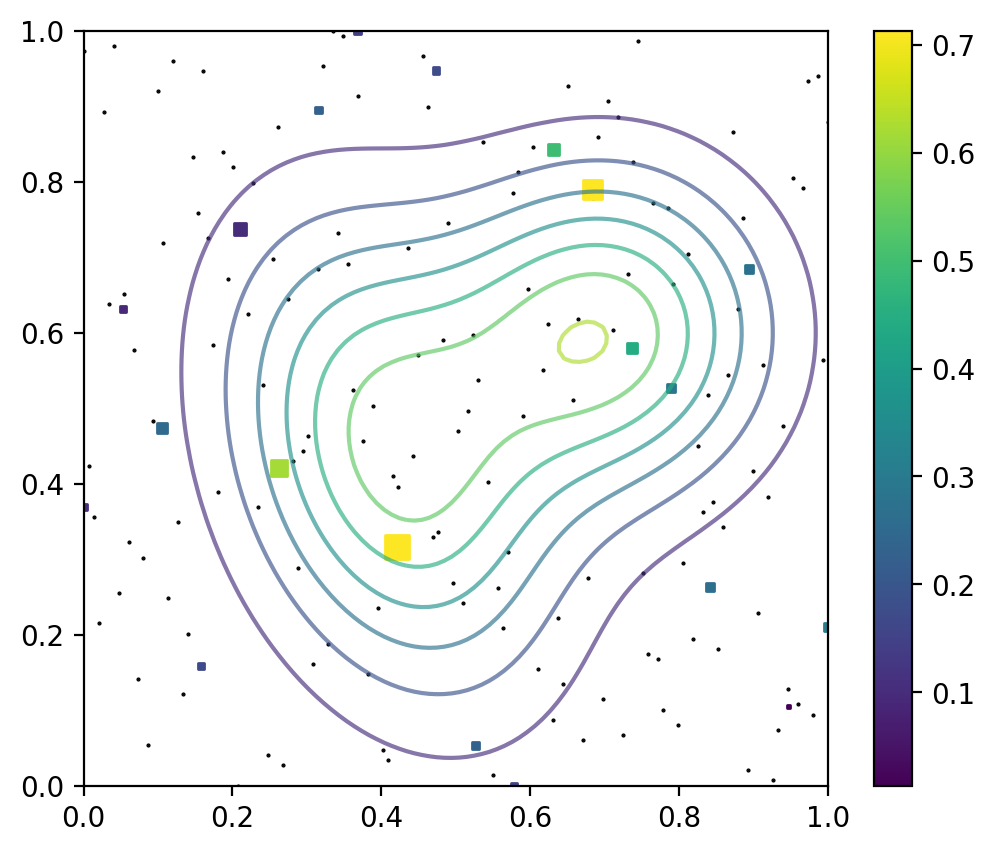

In [150]:
plt.figure(figsize=(6,5), dpi=200)

plt.contour(t,t,f(Xt),alpha=0.65)
plt.scatter(Xi[:,0],Xi[:,1], c='k', marker='.', s=1)

size = 1./(err/pred)
size = size/size.max()*75

plt.scatter(X[:,0],X[:,1], c=pred, marker='s', s=size)
plt.colorbar()

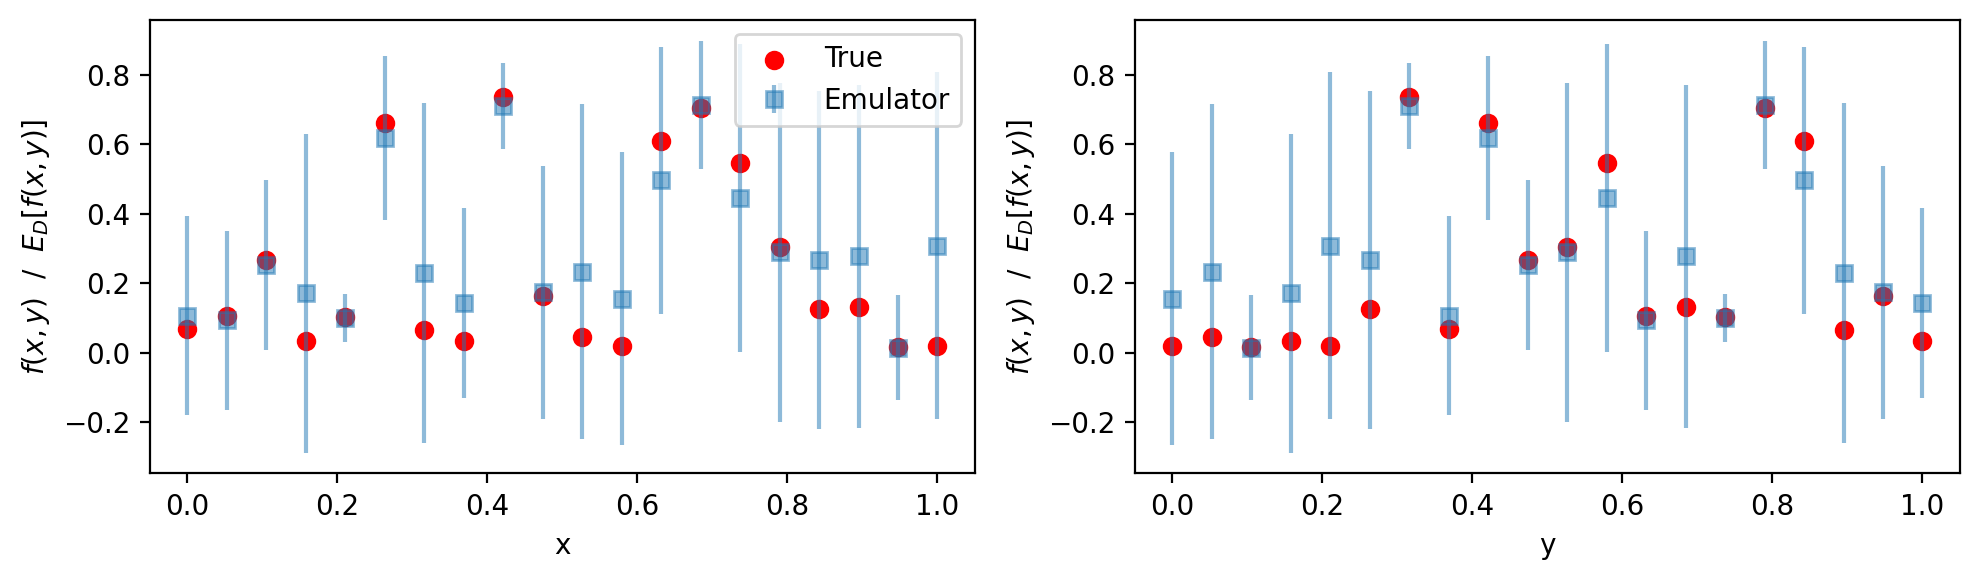

In [151]:
plt.figure(figsize=(10,3), dpi=200)
plt.subplot(121)
plt.scatter(X[:,0], f(X).ravel(),c='r', marker='o', label='True')
plt.errorbar(X[:,0], pred.ravel(), err.ravel(), 
             linestyle='none', marker='s', alpha=0.5, label='Emulator')
plt.xlabel('x')
plt.ylabel('$f(x,y)$  /  $E_D[f(x,y)]$')
plt.legend()
plt.subplot(122)
plt.scatter(X[:,1], f(X).ravel(),c='r', marker='o')
plt.errorbar(X[:,1], pred.ravel(), err.ravel(), 
             linestyle='none', marker='s', alpha=0.5)
plt.xlabel('y')
plt.ylabel('$f(x,y)$  /  $E_D[f(x,y)]$')
plt.tight_layout()


It all looks very nice, but it is necessary to find a way of specifying the hyperparameters $l$ and $\sigma$. 